Analysis of recent coronavirus data for different countries and regions.  
Javier Moldon. More info in https://github.com/jmoldon/coronavirus_analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates


In [2]:
matplotlib.rcParams["figure.figsize"] = 20,9
import warnings
warnings.filterwarnings('ignore')

# Load the data

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [3]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
data_path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

In [4]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

In [5]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [6]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)

Names of available countries (Note, some countries are divided in province/State

In [7]:
#data['Country/Region'].unique()

List of most affected countries (sorted by number of confirmed cases)

In [8]:
data.groupby(['Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].sum().sort_values(by='Confirmed')[::-1][0:15]

,Confirmed,Deaths,Recovered
Country/Region,,,
China,2719449,87028,1089238
"Korea, South",96672,661,2339
Italy,84484,4505,6893
Iran,75645,2855,21060
Cruise Ship,19172,116,1269
France,15660,304,258
Germany,14611,17,439
Spain,12851,288,542
US,9163,263,191


List of most affected countries/provinces (sorted by number of deaths)

In [9]:
data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].sum().sort_values(by='Deaths')[::-1][0:15]

Confirmed  Deaths  Recovered
Country/Region Province/State                              
China          Hubei             2216904   83706     809753
Italy                              84484    4505       6893
Iran                               75645    2855      21060
Korea, South                       96672     661       2339
China          Henan               49080     636      29745
               Heilongjiang        17162     428       8220
France         France              15627     304        258
Spain                              12851     288        542
China          Beijing             16200     202       7220
               Chongqing           22897     197      12268
               Anhui               37747     191      21849
               Guangdong           53211     185      28163
               Hebei               11591     184       7333
               Hainan               6564     177       3739
               Shandong            25981     151      13117

# Evolution of Confirmed cases and Death per country

Left: log scale, right: linear scale, separating cases and deaths. The fit is a logistic growth when possible. If the fit does not converge (early stages), then a simple exponential is used.

In [10]:
def select_country(data, country='', province='', start_date='2020-02-15', end_date='2021-03-11', show_numbers=False):
    print(f'{country} {province}')
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if show_numbers:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

In [11]:
def my_exponential(t,  b, alpha):
    return  b * np.exp(alpha * (t-t[0])/t[0])

def my_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def fit_data(data):
    # Will try to fit a logistic growth. If not possible fit an exponential
    for column in ['Confirmed', 'Deaths', 'Recovered']:
        x = mdates.date2num(data['DateTime'])
        y = data[column].values
        try:
            popt, pcov = curve_fit(my_logistic, x, y, p0=(np.max(y), 1, x[-3]))
            func = my_logistic
        except RuntimeError:
                popt, pcov = curve_fit(my_exponential, x, y, p0=(1., 1))
                func = my_exponential
        c_fit = func(x, *popt)
        data.loc[:, column+'_fit'] = c_fit
    return data

#def fit_data(data, fit='exp'):
#    # Choose between exponential or logistic fit
#    for column in ['Confirmed', 'Deaths', 'Recovered']:
#        try:
#            x = mdates.date2num(data['DateTime'])
#            y = data[column].values
#            if fit=='exp':
#                popt, pcov = curve_fit(my_exponential, x, y, p0=(1., 1))
#                func = my_exponential 
#            elif fit=='logistic':
#                popt, pcov = curve_fit(my_logistic, x, y, p0=(np.max(y), 1, x[-3]))
#                func = my_logistic
#            c_fit = func(x, *popt)
#            data.loc[:, column+'_fit'] = c_fit
#        except RuntimeError:
#            data.loc[:, column+'_fit'] = np.nan
#    return data

In [12]:
def plot_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2021-03-12', show_numbers=False):
    data_country = fit_data(select_country(data, country=country, province=province, start_date=start_date, end_date=end_date, show_numbers=show_numbers))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)

    ax1.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color='#3498db', label='Confirmed')
    ax1.plot(data_country['DateTime'], data_country['Deaths'], 'o', color='tomato', label='Deaths')
    ax1.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country['DateTime'], data_country['Deaths_fit'], '-', color='tomato')
    ax2.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color='#3498db')
    ax2.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color='#3498db')
    ax3.plot(data_country['DateTime'], data_country['Deaths'], 'o', color='tomato')
    ax3.plot(data_country['DateTime'], data_country['Deaths_fit'], '-', color='tomato')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.set_ylim(0.5,)
    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=150)
    return data_country

Spain 


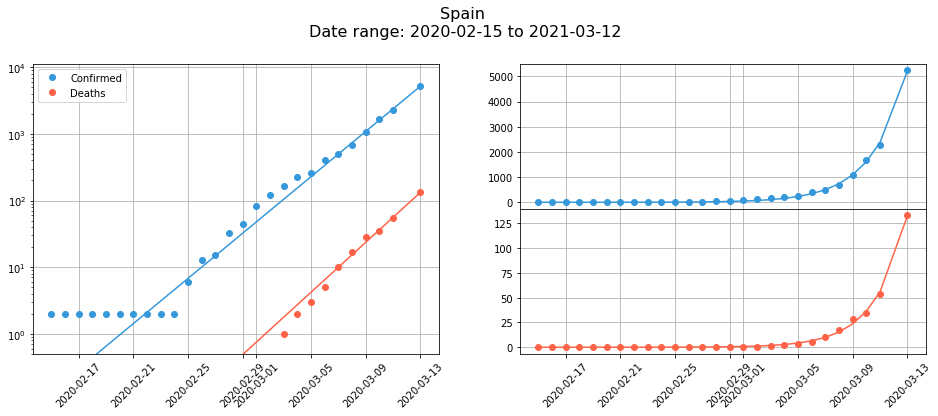

In [13]:
spain = plot_country(data, country='Spain')

Italy 


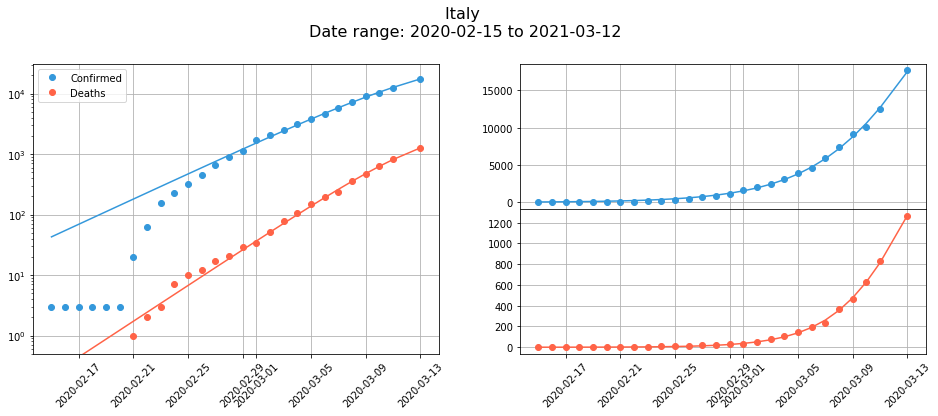

In [14]:
italy = plot_country(data, country='Italy')

Korea, South 


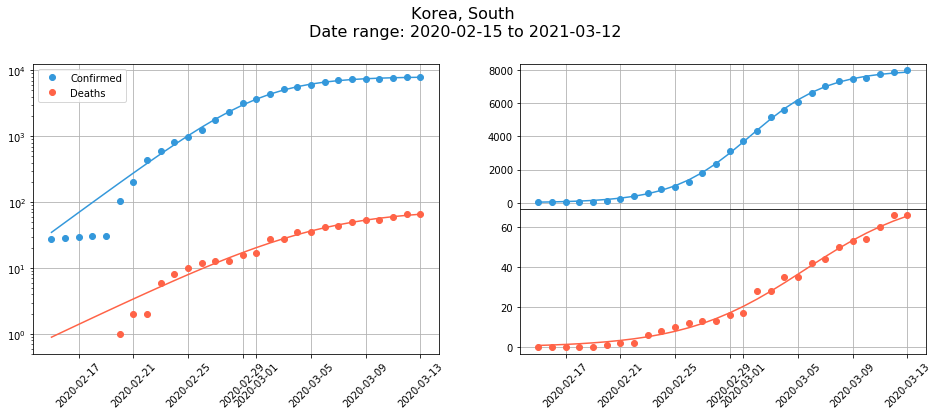

In [15]:
korea = plot_country(data, country='Korea, South')

France France


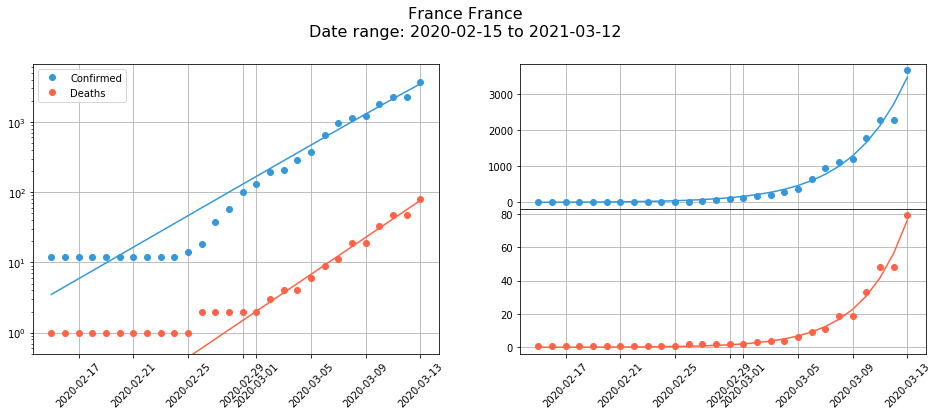

In [16]:
france = plot_country(data, country='France', province='France')

United Kingdom United Kingdom


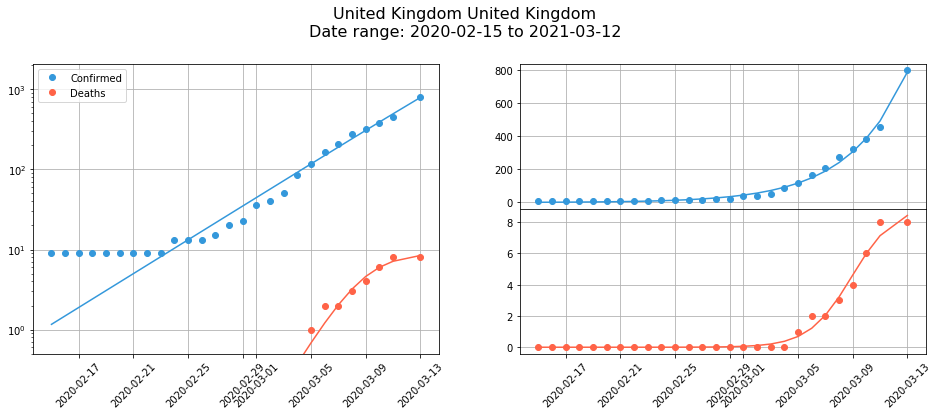

In [17]:
uk = plot_country(data, country='United Kingdom', province='United Kingdom')

Ireland 


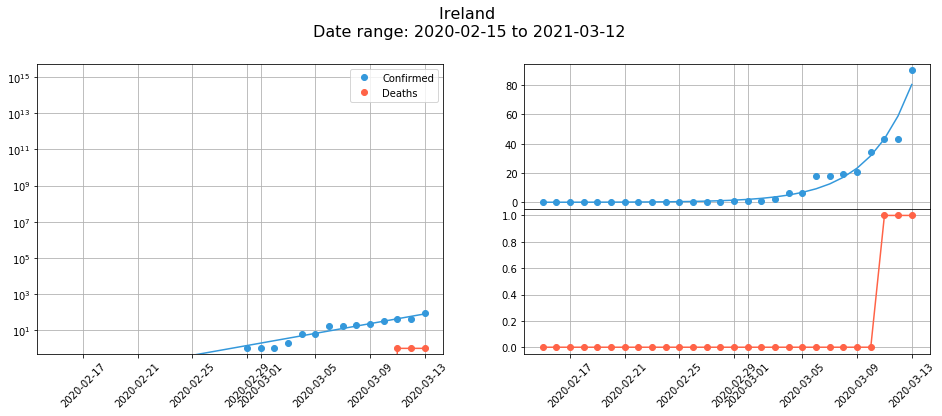

In [18]:
ireland = plot_country(data, country='Ireland')

Denmark Denmark


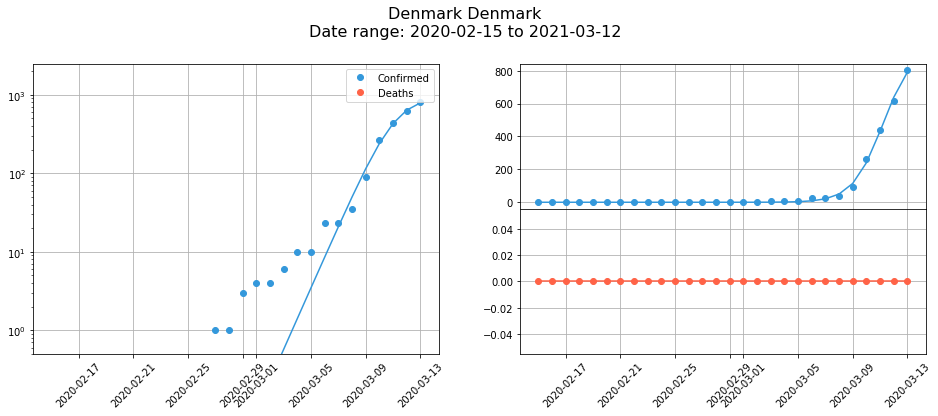

In [19]:
denmark = plot_country(data, country='Denmark', province='Denmark')

Iran 


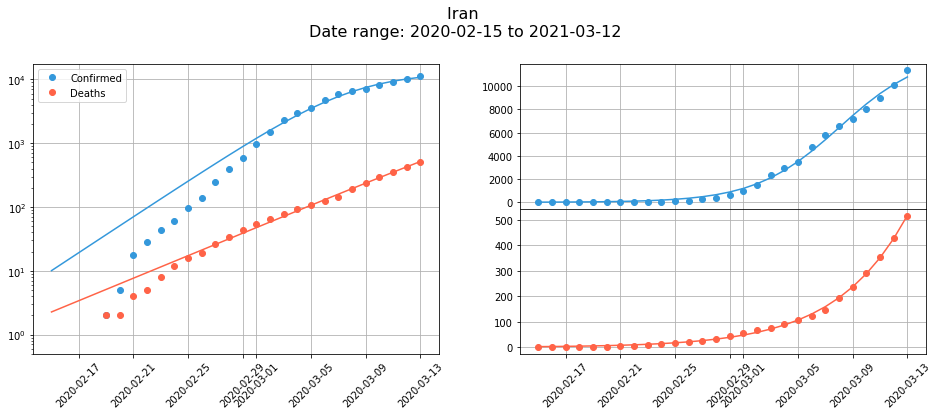

In [20]:
iran = plot_country(data, country='Iran')

# Comparison of two countries, with a manual time delay to align them

In [21]:
def compare_countries(data, country1='Spain', province1='', start_date1='2020-02-15', end_date1='2020-03-12',
                       country2='Spain', province2='', start_date2='2020-02-15', end_date2='2020-03-12',
                       delay=0, show_numbers=False):
    data_country1 = fit_data(select_country(data, country=country1, province=province1, start_date=start_date1, end_date=end_date1, show_numbers=False))
    data_country2 = fit_data(select_country(data, country=country2, province=province2, start_date=start_date2, end_date=end_date2, show_numbers=False))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1+' Confirmed')
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2+' Confirmed')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1+' Deaths')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2+' Deaths')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax1.set_yscale('log')
    
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2)
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k') 
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1)
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2)
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax3.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1)
    ax3.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    
    ax1.legend()
    ax1.set_ylim(0.5,)
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)

    fig.suptitle(f'{country1} vs {country2}\nTime delay added: {delay} days', fontsize=16)
    fig.savefig(f'./plots/{country1}{province1}_{country2}{province2}.png', bbox_inches='tight', dpi=150)

    

Spain 
Italy 


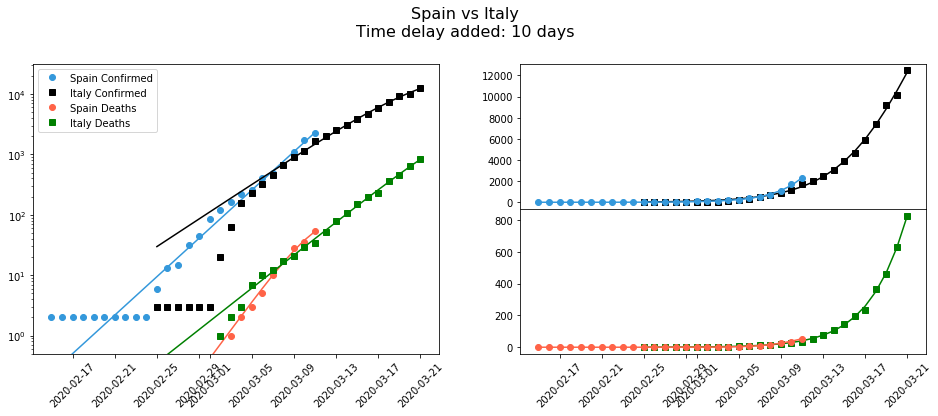

In [22]:
compare_countries(data, country2='Italy', delay=10, show_numbers=False)

Germany 
Italy 


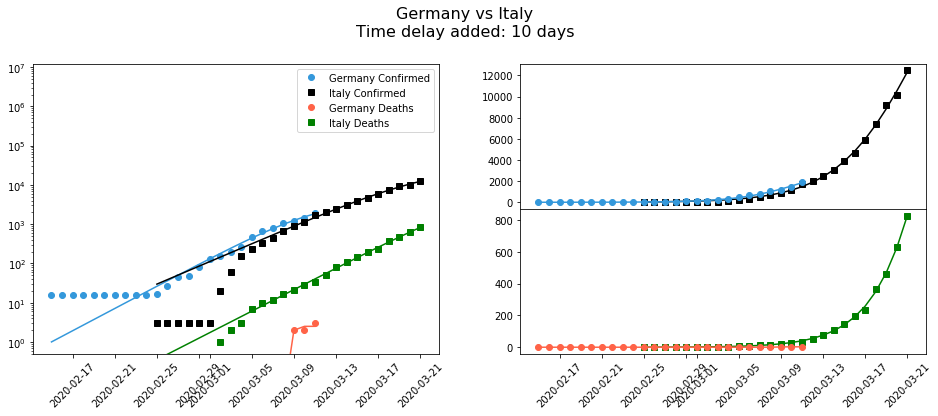

In [23]:
compare_countries(data, country1='Germany', country2='Italy', delay=10)

Korea, South 
Italy 


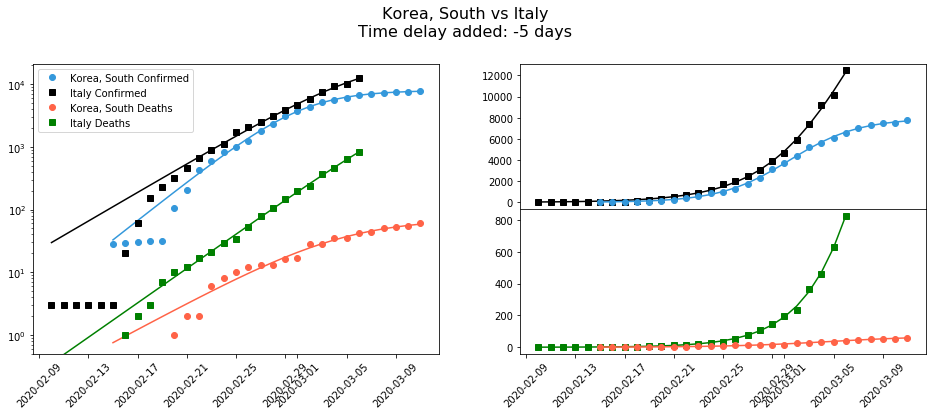

In [24]:
compare_countries(data, country1='Korea, South', country2='Italy', delay=-5)

# Additional plots for other countries

Show plots for the most affected country/province

China Hubei
Italy 
Iran 
Korea, South 
China Henan
China Heilongjiang
France France
Spain 
China Beijing
China Chongqing
China Anhui
China Guangdong
China Hebei
China Hainan
China Shandong
Japan 
US Washington
China Hunan
Cruise Ship Diamond Princess
China Tianjin


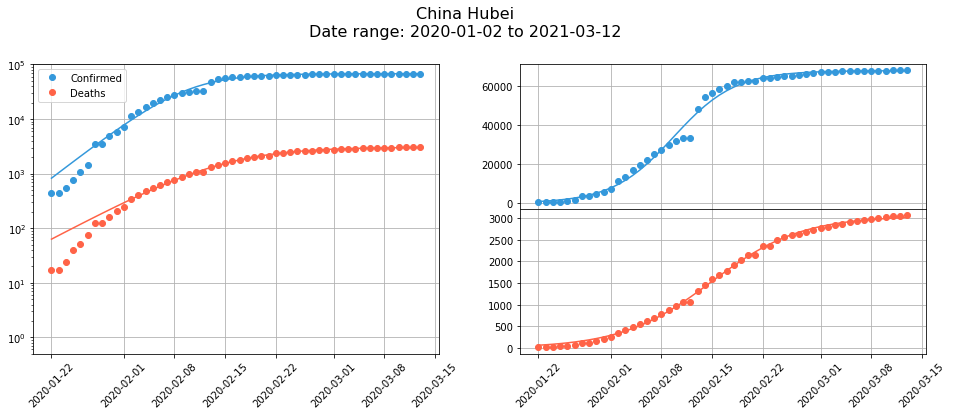

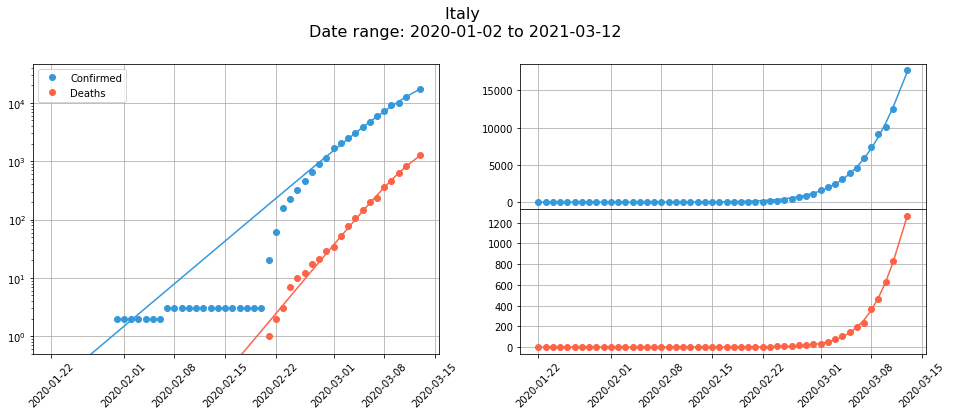

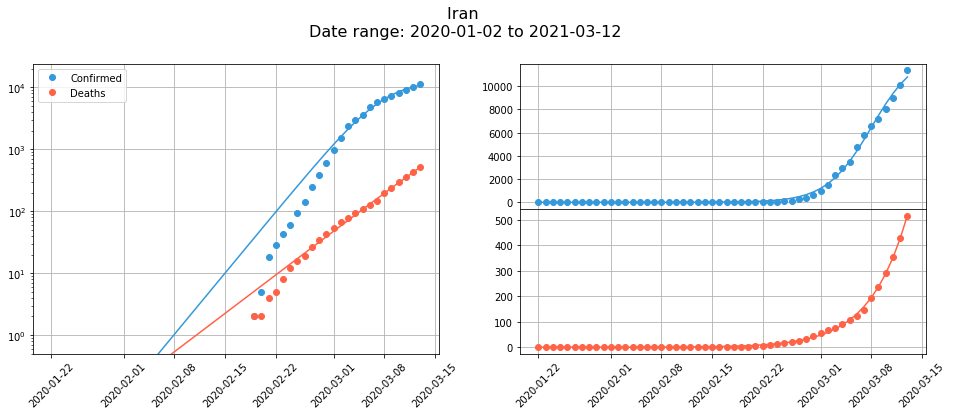

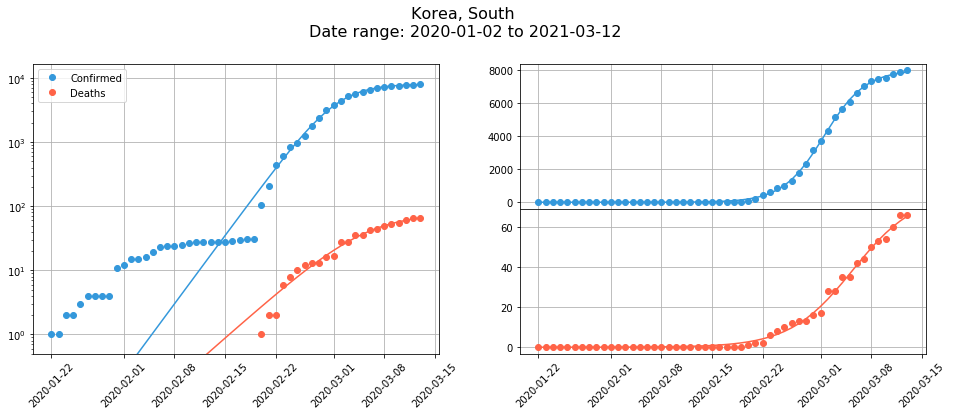

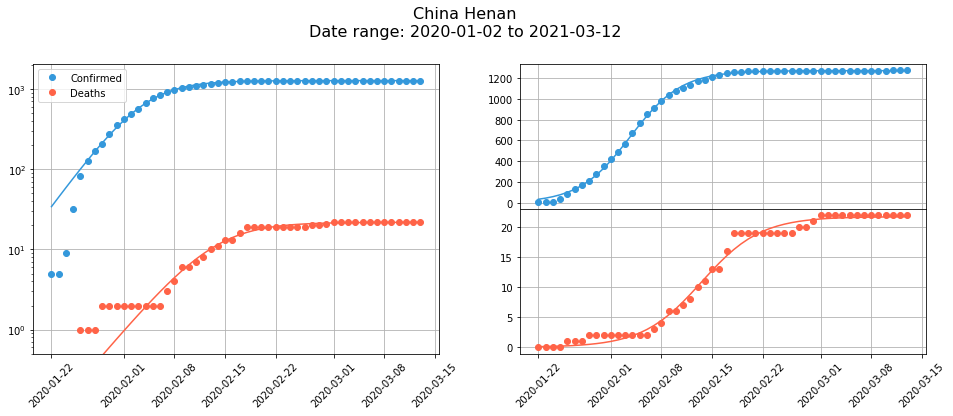

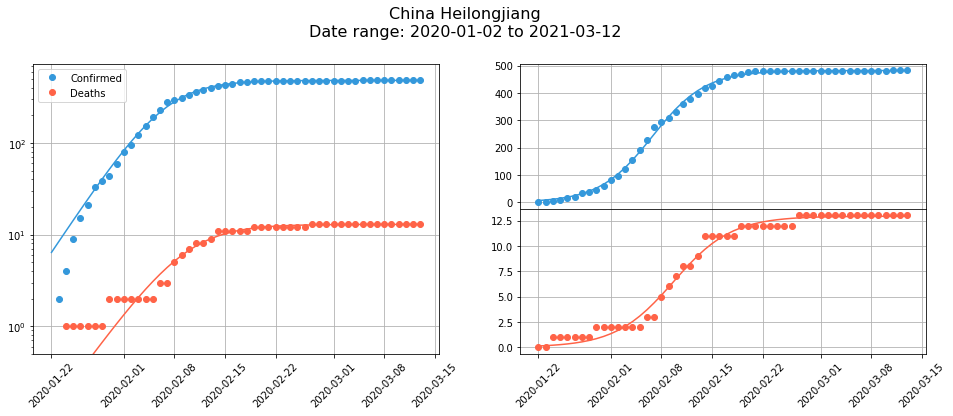

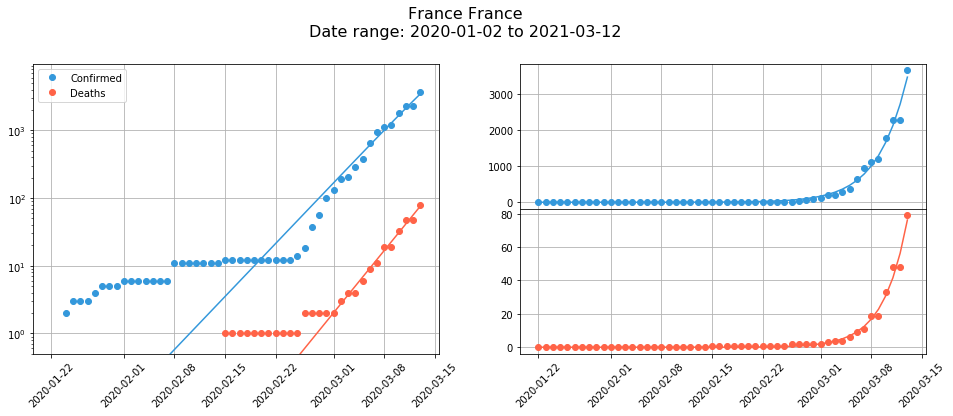

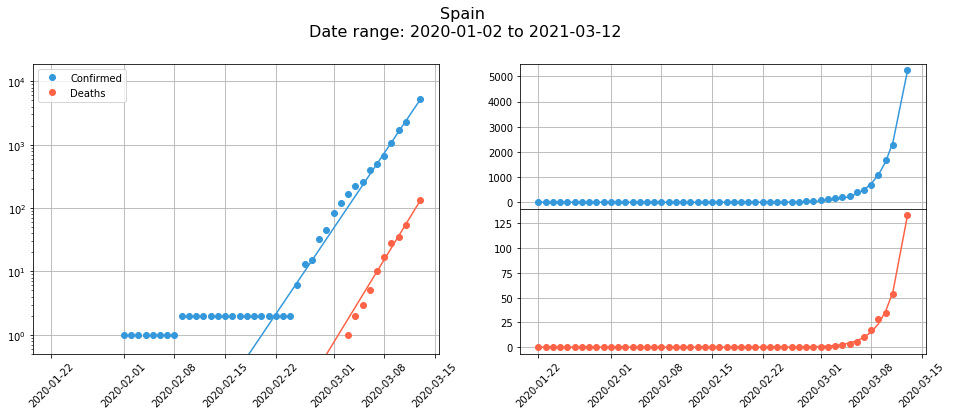

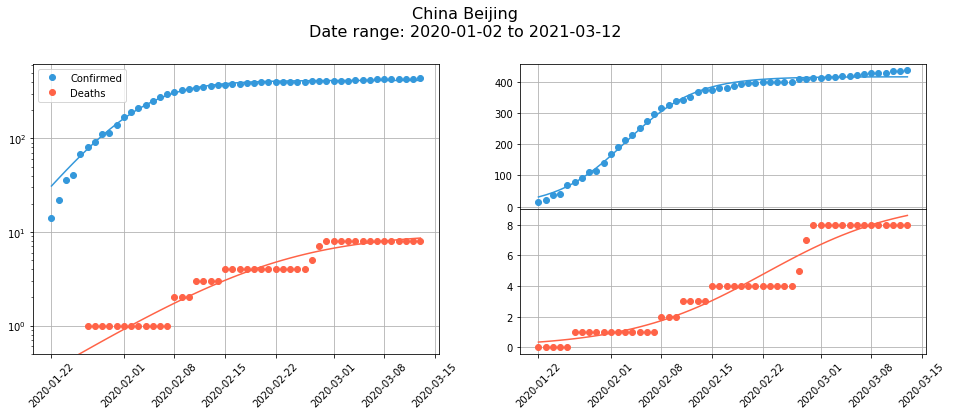

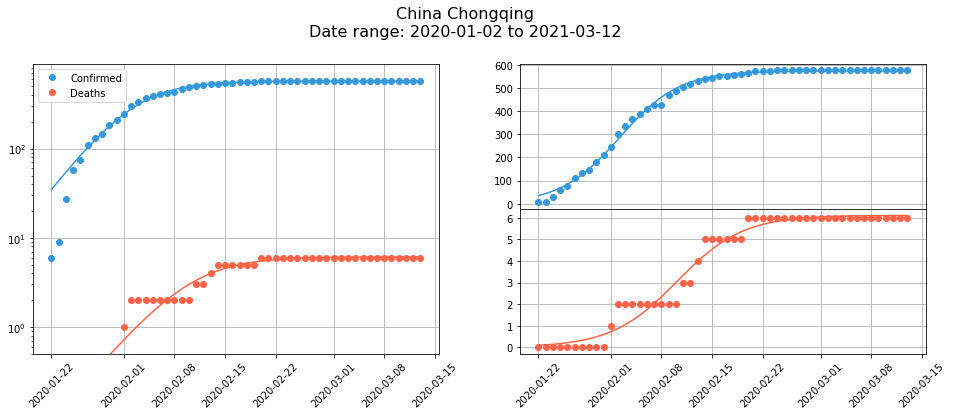

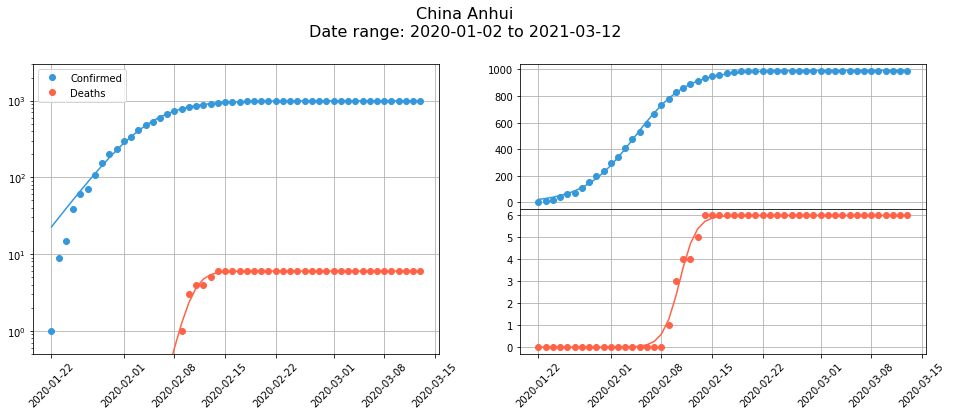

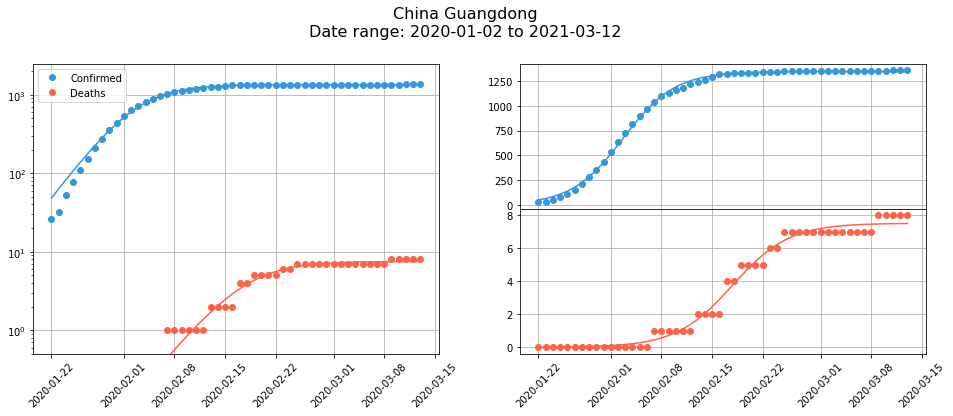

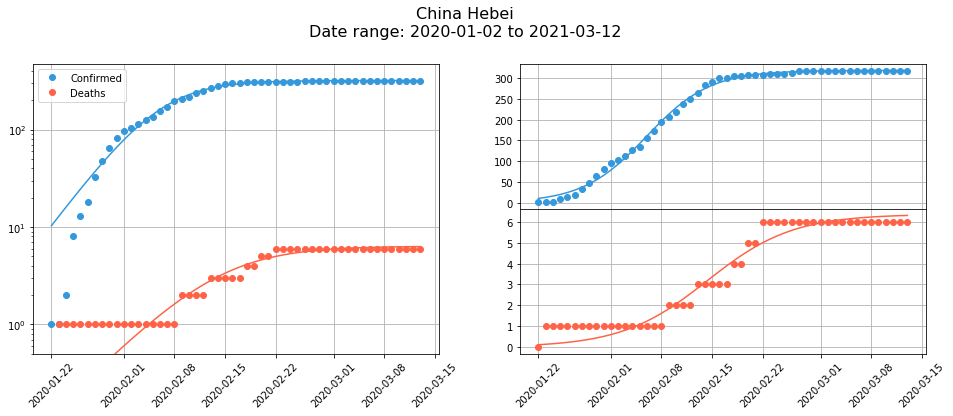

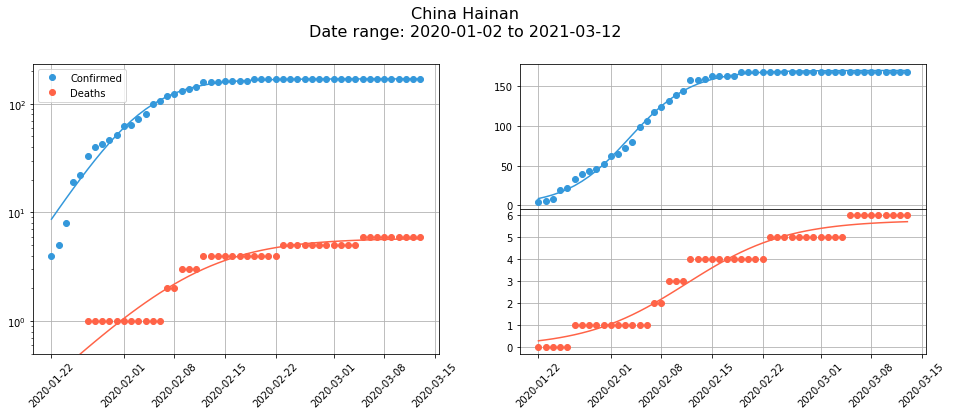

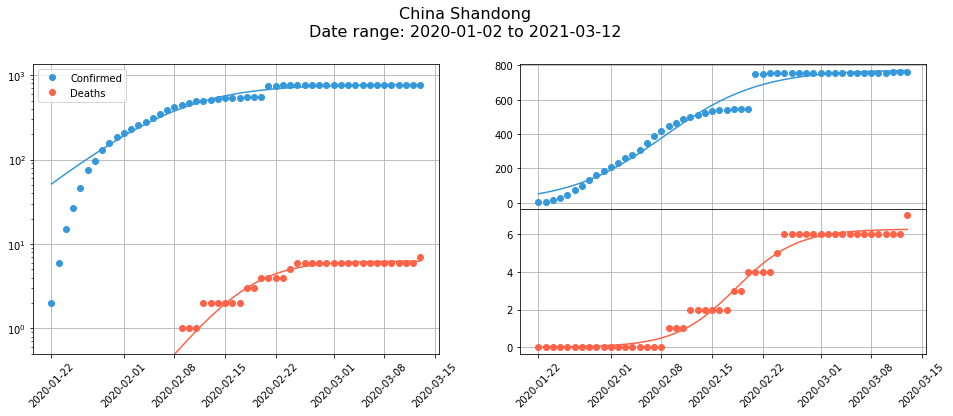

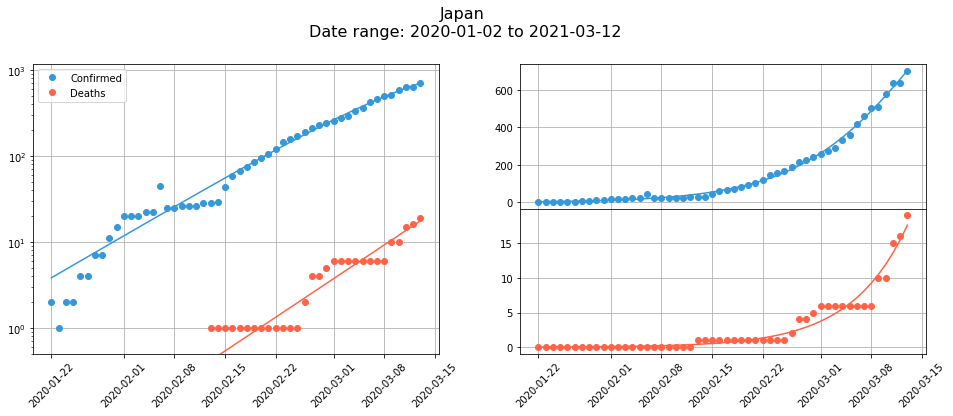

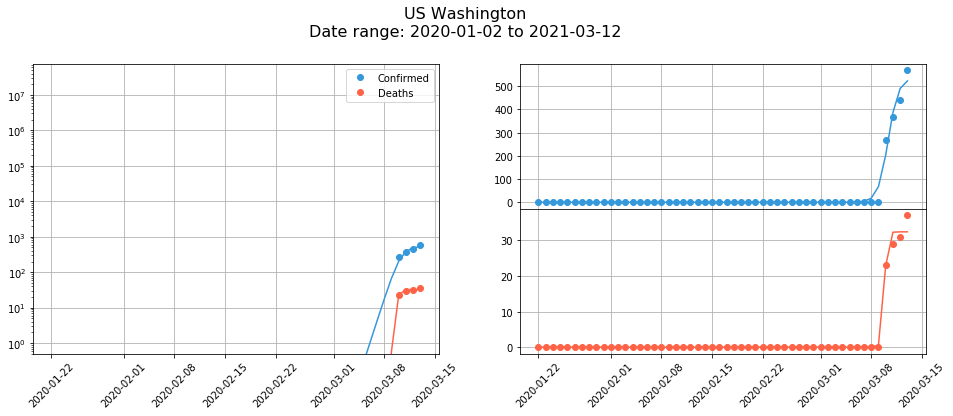

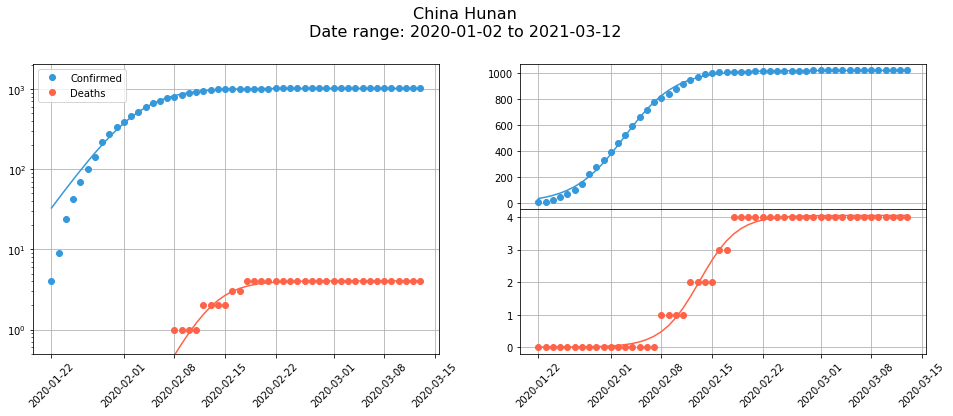

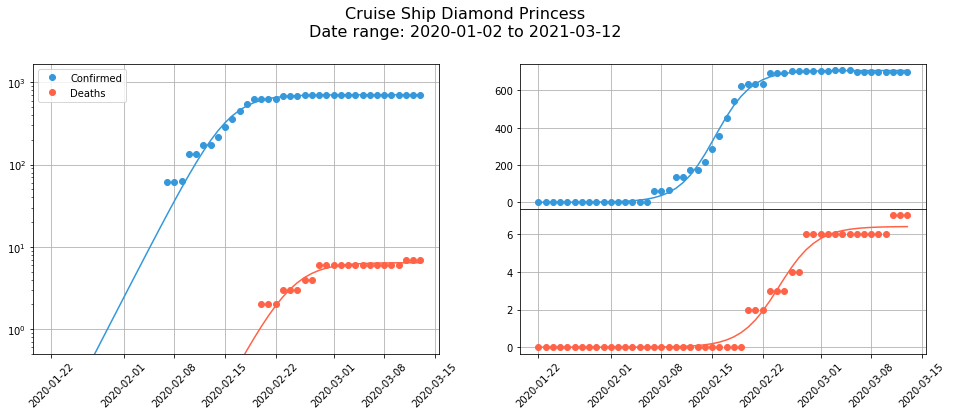

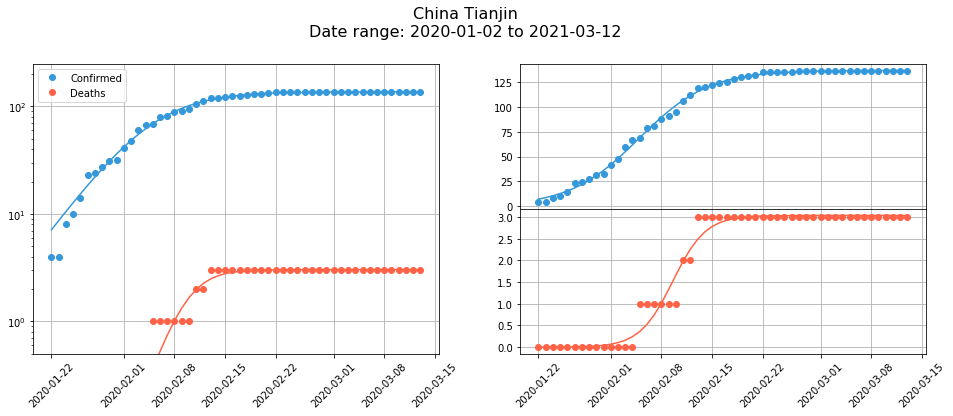

In [25]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:20].index
for i in idx:
    country, province = i
    plot_country(data, country=country, province=province, start_date='2020-01-02', show_numbers=False)